## Hierarchical DBSCAN - HDBSCAN

#### Çınar Turhan, Hildebrand Department of Petroleum and Geosystems Engineering, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/cinarturhan/)

### Subsurface Machine Learning Course, The University of Texas at Austin
#### Hildebrand Department of Petroleum and Geosystems Engineering, Cockrell School of Engineering
#### Department of Geological Sciences, Jackson School of Geosciences




_____________________

Workflow supervision and review by:

#### Instructor: Prof. Michael Pyrcz, Ph.D., P.Eng., Associate Professor, The Univeristy of Texas at Austin
##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Course TA: Misael Morales, Graduate Student, The University of Texas at Austin
##### [LinkedIn](https://www.linkedin.com/in/misaelmmorales/)


### Executive Summary

Clustering algorithms are widely used to observe or estimate the optimum clusters in a dataset. One of the widely used clustering algorithms is the DBSCAN algorithm. However, it has a significant downside: its sensitivity to noise. This project demonstrates a clustering algorithm, HDBSCAN, that is more robust and faster than DBSCAN. The methodology that is stated here is composed of building an example of HDBSCAN clustering and comparing it to DBSCAN to obtain a faster and less noise-sensitive model with a single hyperparameter (unlike DBSCAN). The approach includes the utilization of different datasets and also an illustration of the computational time difference between these two algorithms.

### Packages

In [1]:
import numpy as np                             # for basic array operations
import pandas as pd                            # for creating a tabular form for the data
import matplotlib.pyplot as plt                # for plotting/visualizing the results
import seaborn as sns                          # for plotting/visualizing the results
from sklearn.preprocessing import MinMaxScaler # for normalizing the data
from sklearn.cluster import DBSCAN             # for DBSCAN clustering
import hdbscan                                 # for HDBSCAN clustering
import time                                    # for calculating the runtimes
from sklearn.neighbors import NearestNeighbors # for calculating the epsilon hyperparameter
import copy                                    # for creating deep copies
palette = plt.cm.tab20                         # a good colormap
import warnings
warnings.filterwarnings('ignore')

This workflow uses the implementation and illustration of DBSCAN, with several modifications, from the notebook "SubsurfaceDataAnalytics_advanced_clustering.ipynb" to make the comparisons between DBSCAN and HDBSCAN. 

Workflow can be found here: [GeostatsGuy Advanced Clustering](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb)

### Functions

In [2]:
# Plot Configurations for arranging title, limits, labels, fontsizes, and plot locations.
def arrange_plot(title,xlabel,ylabel,xlim=None,ylim=None,size=None):
    if size == 'Small':
        plt.title(title);plt.xlabel(xlabel);plt.ylabel(ylabel)
    else:
        plt.title(title, fontsize=16);plt.xlabel(xlabel, fontsize=14);plt.ylabel(ylabel, fontsize=14)
    plt.xlim(xlim);plt.ylim(ylim);plt.grid(alpha=0.8)
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2) # From GeostatsGuy workflows
    
def create_cmap(n_colors,palette):
    a = {}
    palette = sns.color_palette(palette=palette, n_colors=n_colors, desat=0.8, as_cmap=False)
    for i in range(0,n_colors):
        color = palette[i:i+1][0]
        count = n_colors/n_colors+i
        a.update({count-1:color})
    return a

### Loading the Data

The dataset used in this workflow is taken from the GitHub page of Prof. Michael Pyrcz, also known as Geostats Guy. It can be found in the link: [Data from GeostatsGuy](https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v1.csv)

The following features are used in this workflow.

* **Porosity** - The ratio of the void volume to the ratio of the total volume of a porous medium. Its unit is percentage.
* **Permeability** - The measure of ease of fluid flow inside a porous medium. Its unit is millidarcy.
* **Facies** - The characteristic of the rock/porous medium. Unitless.

Summary statistics of the data - nPor and nPerm indicate the normalized values for the features:

|        |   count |       mean |        std |   min |        25% |         50% |         75% |   max |
|:-------|--------:|-----------:|-----------:|------:|-----------:|------------:|------------:|------:|
|**Por**    |    1700 |  15.9      |   7.24166  |     0 |  10        |   18.3433   |   21.7538   |    30 |
|**Perm**   |    1700 | 982.425    | 220.904    |    10 | 847.051    | 1065.01     | 1154.05     |  1200 |
|**Facies** |    1700 |   1.64706  |   0.836285 |     1 |   1        |    1        |    2        |     3 |
|**nPor**   |    1700 |   0.530001 |   0.241389 |     0 |   0.333333 |    0.611444 |    0.725128 |     1 |
|**nPerm**  |    1700 |   0.817164 |   0.185633 |     0 |   0.703405 |    0.886565 |    0.961389 |     1 |

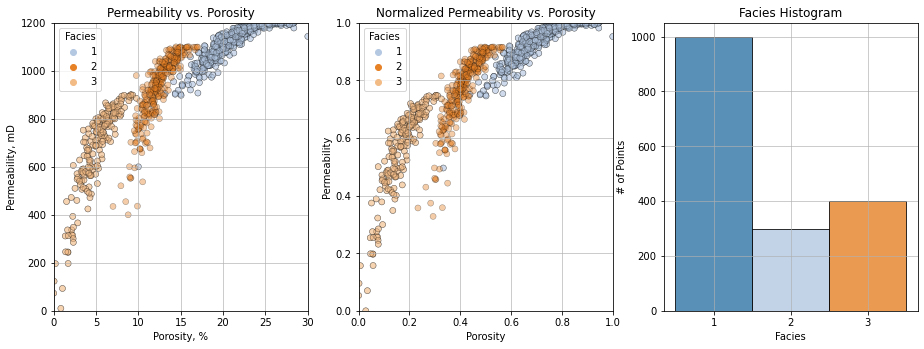

In [3]:
# Importing the data
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v1.csv',index_col=0)

# Defining the limits for the plotting purposes.
xlim = [0,1]; ylim = [0,1]; xlabel = 'Porosity, %'; ylabel = 'Permeability, mD'

# Normalizing the data for working with DBSCAN and HDBSCAN
transform = MinMaxScaler(); 
df['nPor'] = transform.fit_transform(df.values)[:,0]
df['nPerm'] = transform.fit_transform(df.values)[:,1]
cmap = create_cmap(4,'tab20')

# Plotting the data
plt.subplot(131)
sns.scatterplot(df['Por'], df['Perm'], hue=df['Facies'], alpha = 0.4, palette = cmap, edgecolor="black")
arrange_plot('Permeability vs. Porosity','Porosity, %','Permeability, mD',[0,30],[0,1200],size='Small')

plt.subplot(132)
sns.scatterplot(df['nPor'], df['nPerm'], hue=df['Facies'], alpha = 0.4, palette = cmap, edgecolor="black")
arrange_plot('Normalized Permeability vs. Porosity','Porosity','Permeability',xlim,ylim,size='Small')

plt.subplot(133)
N, bins, patches  = plt.hist(df['Facies'],alpha=0.8,edgecolor="black",bins=[0.5,1.5,2.5,3.5],range=[0.5,2.5])
for i in range(0,len(cmap)-1):
    patches[i].set_facecolor(cmap[i][:])
plt.xticks([1,2,3]);arrange_plot('Facies Histogram','Facies','# of Points',size='Small')

### Workflow Overview


**Step 1 - Implementation of DBSCAN** <br>
The DBSCAN algorithm is implemented in this step, and clustering results are shown. For more detailed information about DBSCAN, check the reference: [GeostatsGuy Advanced Clustering](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb)

**Step 2 - Implementation of HDBSCAN** <br>
This step illustrates and explains the HDBSCAN algorithm and shows the clustering results for the dataset

**Step 3 - Results** <br>
Results include the side-by-side visual comparison of two algorithms, including their runtime differences.

### Step 1. Implementation of DBSCAN

This is the classification result from [GeostatsGuy Advanced Clustering](https://github.com/GeostatsGuy/PythonNumericalDemos/blob/master/SubsurfaceDataAnalytics_advanced_clustering.ipynb). The code is modified to match the bin colors histogram with the clusters from the plot. Unless the hyperparameters are set to extremes that will result in more than 20 clusters or less than a cluster, the colors will adjust. <br>

The epsilon hyperparameter can be optimized using the nearest neighbors algorithm; however, the optimized epsilon (around 0.01) does not result in the best result for this case.

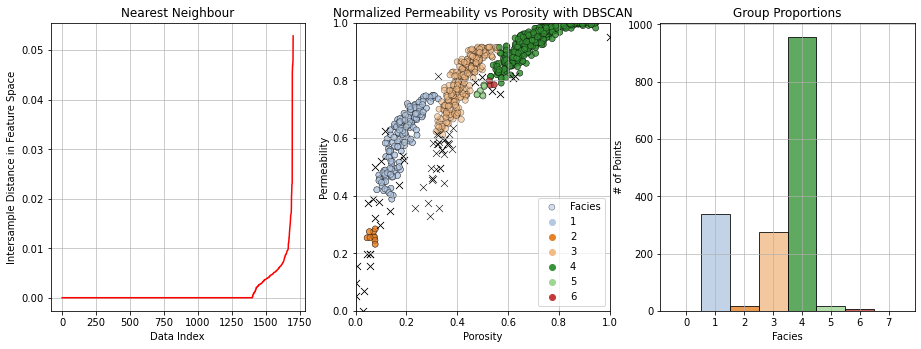

In [4]:
time0 = time.time()
dbscan = DBSCAN(eps=0.029, min_samples=15).fit(df[['nPor','nPerm']].values)
dbscan_time = round((time.time() - time0),4)
df['DBSCAN'] = dbscan.labels_ + 1
df_inlier = df.loc[(df['DBSCAN'] != 0)]
df_outlier = df.loc[(df['DBSCAN'] == 0)]
vals = df['DBSCAN'].unique();vals.sort();n_colors=vals.shape[0] # Arranging the color palette size
cmap = create_cmap(n_colors,'tab20')

plt.subplot(131)
neigh = NearestNeighbors(algorithm='kd_tree')
nbrs = neigh.fit(df[['nPor','nPerm']].values)
distances, indices = nbrs.kneighbors(df[['nPor','nPerm']].values)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances, c = 'red')
arrange_plot('Nearest Neighbour','Data Index','Intersample Distance in Feature Space',size='Small')

plt.subplot(132)
sns.scatterplot(df_inlier['nPor'], df_inlier['nPerm'], hue=df_inlier['DBSCAN'], alpha=0.6, palette=cmap ,edgecolor="black", label = 'Facies')
sns.scatterplot(df_outlier['nPor'],df_outlier['nPerm'],s=50, marker = 'x', color="black")
arrange_plot('Normalized Permeability vs Porosity with DBSCAN','Porosity','Permeability',xlim,ylim,size='Small')

plt.subplot(133)
N, bins, patches  = plt.hist(df_inlier['DBSCAN'],alpha=0.8,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],range=[0.5,2.5])
for i in range(0,len(cmap)):
    patches[i].set_facecolor(cmap[i][:])
plt.xticks([0,1,2,3,4,5,6,7]);arrange_plot('Group Proportions','Facies','# of Points',size='Small')

### 2. Implementation of HDBSCAN

The following code is the main part of HDBSCAN clustering. <br>
```python
clusterer = hdbscan.HDBSCAN(min_cluster_size=50)
cluster_labels = clusterer.fit_predict(df[['nPor','nPerm']].values)
```
The first line is the initialization of the model with required hyperparameters. HDBSCAN can be utilized with only one hyperparameter, that is the min_cluster_size. Although only one hyperparameter is enough for the algorithm, there are two other optional hyperparameters. The meanings of the parameters are explained below.
* **min_cluster_size:** This is the main hyperparameter that indicates the minimum size of the clusters.
* **min_samples:** This is the minimum number of samples around a point for that point to be a core point (same as DBSCAN)
* **cluster_selection_epsilon:** This is the distance threshold/radius for the linkage points (same as DBSCAN).

There are additional options to modify the output in the model; in this project, however, only min_cluster_size is considered for the illustration of a single hyperparameter model. <br>

The second line is for fitting the model and getting the output.

```python
df2=df.copy(deep=True)
df2['HDBSCAN'] = cluster_labels+1
```
These lines are used for creating a new dataset by adding the clustering results from HDBSCAN. <br>

The rest of the code is for plotting the HDBSCAN for varying min_cluster_size values, in other words, hyperparameter tuning. The choice of min_cluster_size hyperparameter is relatively intuitive - as stated in its documentation. Therefore, the best choice is visualizing the results and deciding on the optimum min_cluster_size. 

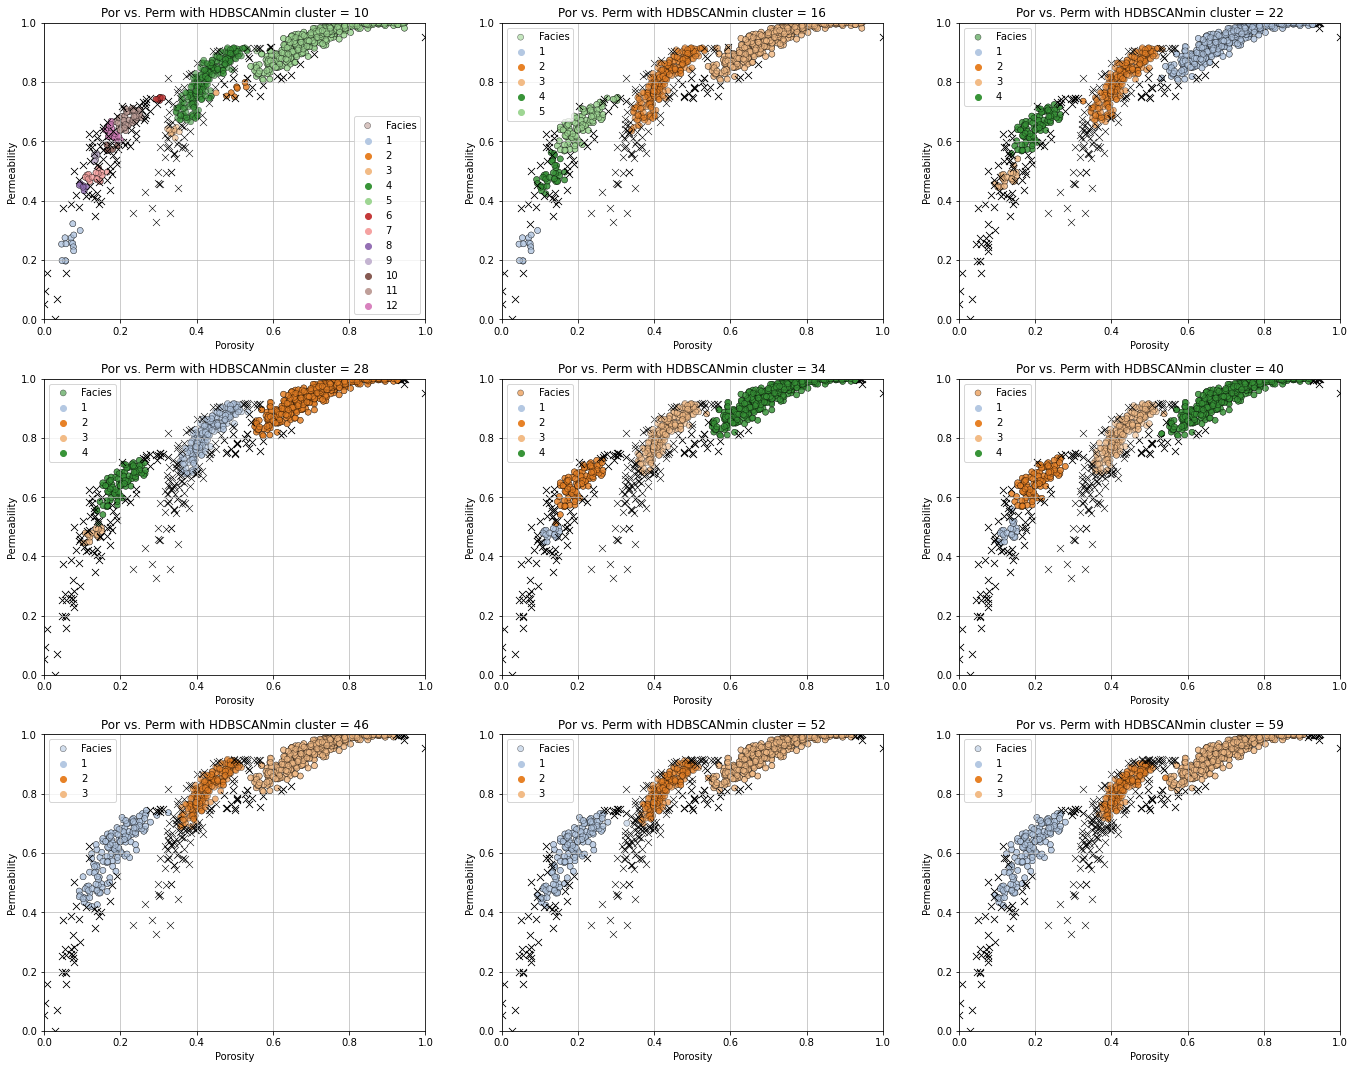

In [5]:
time0 = time.time()
clusterer = hdbscan.HDBSCAN(min_cluster_size=46)
cluster_labels = clusterer.fit_predict(df[['nPor','nPerm']].values)
hdbscan_time = round((time.time() - time0),3)
df2=df.copy(deep=True)
df2['HDBSCAN'] = cluster_labels+1

min_cluster_size = [10, 16, 22, 28, 34, 40, 46, 52, 59]

index = 1
for size in min_cluster_size:
    new_df = df.copy(deep=True)
    clusterer2 = hdbscan.HDBSCAN(min_cluster_size=size)
    cluster_labels = clusterer2.fit_predict(df[['nPor','nPerm']].values)
    new_df['HDBSCAN'] = cluster_labels+1; new_df_in = new_df.loc[(new_df['HDBSCAN'] != 0)]
    new_df_out = new_df.loc[(new_df['HDBSCAN'] == 0)]; vals = new_df['HDBSCAN'].unique(); vals.sort()
    n_colors=vals.shape[0]; cmap_new = create_cmap(n_colors,'tab20')

    plt.subplot(3,3,index)
    sns.scatterplot(new_df_in['nPor'], new_df_in['nPerm'], hue=new_df_in['HDBSCAN'],alpha=0.6,palette=cmap_new, edgecolor="black", label = 'Facies')
    sns.scatterplot(new_df_out['nPor'],new_df_out['nPerm'],s=50, marker = 'x', color="black")
    arrange_plot('Por vs. Perm with HDBSCAN'+ 'min cluster = ' + str(size),'Porosity','Permeability',xlim,ylim,size='Small')
    index = index + 1

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=3.50, wspace=0.2, hspace=0.2)

### Results

The results include the side-by-side comparison of DBSCAN and HDBSCAN. The hyperparameter for HDBSCAN is chosen as 46 from the iterative plots above. For DBSCAN, the optimum hyperparameters are taken as eps=0.029, min_samples=15. <br>

The comparison below includes the visual inspection of both algorithms, run times, and cluster distributions.

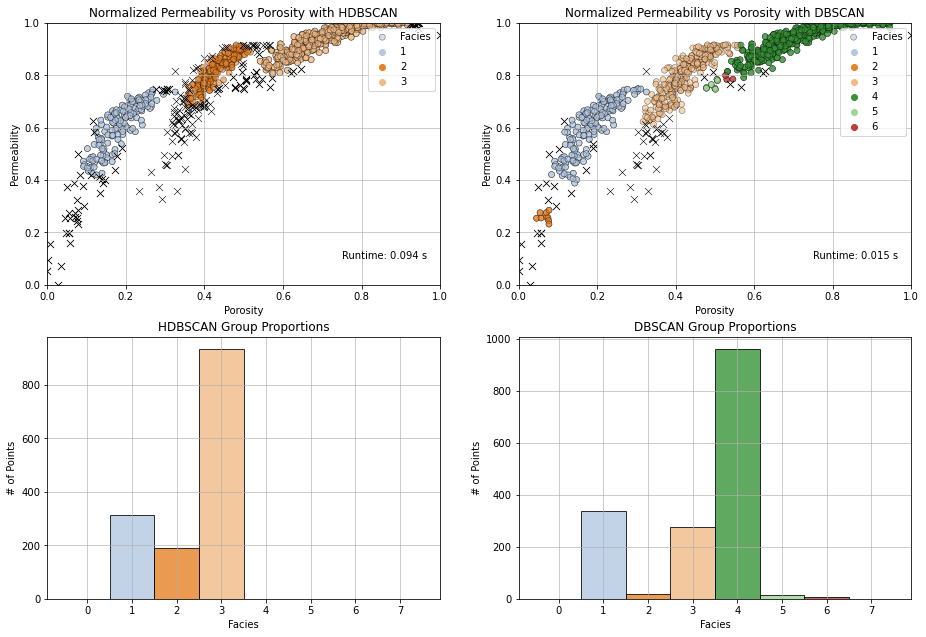

In [6]:
df_inlier2 = df2.loc[(df2['HDBSCAN'] != 0)]
df_outlier2 = df2.loc[(df2['HDBSCAN'] == 0)]
vals = df2['HDBSCAN'].unique();vals.sort();n_colors=vals.shape[0] # Arranging the color palette size
cmap2 = create_cmap(n_colors,'tab20')

plt.subplot(221)
sns.scatterplot(df_inlier2['nPor'],df_inlier2['nPerm'], hue=df_inlier2['HDBSCAN'],alpha=0.6,palette=cmap2, edgecolor="black", label = 'Facies')
sns.scatterplot(df_outlier2['nPor'],df_outlier2['nPerm'],s=50, marker = 'x', color="black")
arrange_plot('Normalized Permeability vs Porosity with HDBSCAN','Porosity','Permeability',xlim,ylim,size='Small')
plt.annotate('Runtime: '+str(hdbscan_time)+' s',(0.75,0.1))

plt.subplot(222)
sns.scatterplot(df_inlier['nPor'], df_inlier['nPerm'], hue=df_inlier['DBSCAN'], alpha=0.6, palette=cmap, edgecolor="black", label = 'Facies')
sns.scatterplot(df_outlier['nPor'],df_outlier['nPerm'],s=50, marker = 'x', color="black")
arrange_plot('Normalized Permeability vs Porosity with DBSCAN','Porosity','Permeability',xlim,ylim,size='Small')
plt.annotate('Runtime: '+str(dbscan_time)+' s',(0.75,0.1))

plt.subplot(223)
N, bins, patches  = plt.hist(df_inlier2['HDBSCAN'],alpha=0.8,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],range=[0.5,2.5])
for i in range(0,len(cmap2)):
    patches[i].set_facecolor(cmap2[i][:])
plt.xticks([0,1,2,3,4,5,6,7]);arrange_plot('HDBSCAN Group Proportions','Facies','# of Points',size='Small')

plt.subplot(224)
N, bins, patches  = plt.hist(df_inlier['DBSCAN'],alpha=0.8,edgecolor="black",bins=[-0.5,0.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5],range=[0.5,2.5])
for i in range(0,len(cmap)):
    patches[i].set_facecolor(cmap[i][:])
plt.xticks([0,1,2,3,4,5,6,7]);arrange_plot('DBSCAN Group Proportions','Facies','# of Points',size='Small')
plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.0, wspace=0.2, hspace=0.2)

**There are several conclusions that can be inferred from these results:
* The runtimes show that HDBSCAN is not faster than DBSCAN in this case; however, HDBSCAN is faster than DBSCAN when the dataset is enlargened (see the plots below).
* In HDBSCAN, the number of clusters can be actually chosen by changing the hyperparameter, whereas the same thing requires more effort in DBSCAN since there are two hyperparameters. This phenomenon also shows that HDBSCAN can deal with noise better than DBSCAN.
* The distributions of the clusters are pretty close to the original in both algorithms; however, DBSCAN has a better distribution between its three largest clusters, giving a very close result to the original distribution. 

The section below gives an insight into the runtimes of the algorithms using the same dataset with an increasing number of data (normal distribution). Moreover, the dendrogram plot visualizes the hierarchy between the clusters (for the original dataset). Each ellipse indicates the chosen cluster, and the size of the ellipse indicates its relative size.

Text(0.5, 1.0, 'Dendrogram')

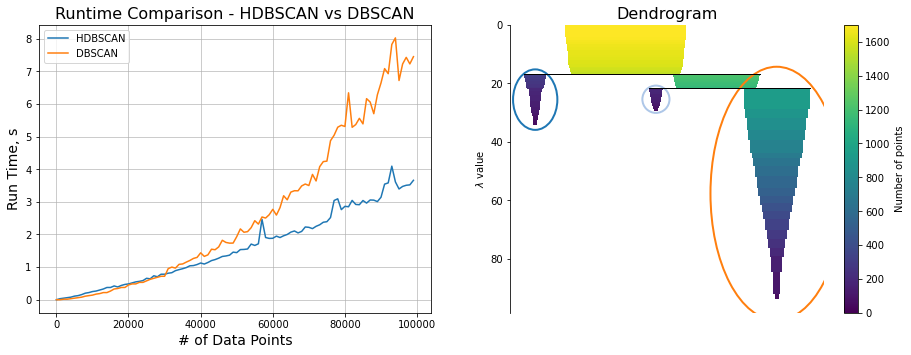

In [16]:
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/nonlinear_facies_v1.csv',index_col=0)
hdbscan_time_arr = [];dbscan_time_arr = [];i_arr = []
column_names = {0:'Por',1:'Perm',2:'Facies'}
np.random.seed(2018)

for i in range(30,1*10**5,1000):
    df_time = np.random.normal(loc=df.mean(), scale=df.std(), size=(i,3))
    df_time = pd.DataFrame(df_time);df_time.rename(columns=column_names)
    df_time['nPor'] = transform.fit_transform(df_time.values)[:,0]
    df_time['nPerm'] = transform.fit_transform(df_time.values)[:,1]
    time0 = time.time()
    clusterer2 = hdbscan.HDBSCAN(min_cluster_size=30).fit_predict(df_time[['nPor','nPerm']].values)
    hdbscan_time = (time.time() - time0)
    hdbscan_time_arr.append(hdbscan_time)
    time0 = time.time()
    dbscan = DBSCAN(eps=0.029, min_samples=15).fit(df_time[['nPor','nPerm']].values)
    dbscan_time = (time.time() - time0)
    dbscan_time_arr.append(dbscan_time)
    i_arr.append(i)

plt.subplot(121)
plt.plot(i_arr,hdbscan_time_arr, label = 'HDBSCAN')
plt.plot(i_arr,dbscan_time_arr, label = 'DBSCAN')
arrange_plot('Runtime Comparison - HDBSCAN vs DBSCAN', '# of Data Points','Run Time, s')
plt.legend()

plt.subplot(122)
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette('tab20', 8))
plt.title('Dendrogram',fontsize=16)

### About Çınar Turhan

*Petroleum and Natural Gas Engineer - BSc, METU 2022*<br>
*MSc Student at Hildebrand Department of Petroleum and Geosystems Engineering, University of Texas at Austin*<br>
*Graduate Research Assistant at RAPID Research Consortium.* <br>

**Research Interests:**
* Well Integrity
* Well Repurposing
* Carbon Storage
* Geothermal Energy
* Hole Cleaning
* Machine Learning

Feel free to contact me about anything related to this workflow, or to discuss my research.

Sincerely,<br>
*Çınar Turhan*

___________________

### Work Supervised by:

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)